# Sanan Project: Clinical + Sensor Data Analysis (ตามสไลด์, ใช้เฉพาะ Data ที่ให้มา)

เป้าหมาย: โหลดและผสานข้อมูลคลินิก + ข้อมูลเซ็นเซอร์, ทำความสะอาด, สร้างฟีเจอร์, ทำ Data Visual และโมเดลพื้นฐาน เพื่อสรุปเชิงสถิติและสอดคล้องกับงานนำเสนอในสไลด์ (หัวข้อ/แนวคิด).
- Dataset root: `data/` ภายในโปรเจกต์นี้ (Windows paths)
- ใช้เฉพาะข้อมูลที่อยู่ใน `data_0`, `data_1`, ไฟล์ XML, และ sensing_data เท่านั้น
- Notebook นี้แบ่งเป็น 23 ส่วนตามโครงร่างที่กำหนด

In [1]:
# 1) Environment Setup and Library Imports
import sys, os, re, json, math, warnings
from pathlib import Path
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Dict, List, Optional, Iterable, Tuple
from dataclasses import dataclass

# Optional: sklearn for baseline modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_context("talk")

print(f"Python {sys.version}")
print("Libraries imported.")

Python 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
Libraries imported.


In [2]:
# 2) Project Path Configuration and Directory Validation
BASE_PATH = Path(r"c:\\Users\\KritChaJ\\Downloads\\Sanan Project")
DATA_PATH = BASE_PATH / "data"
DATA0 = DATA_PATH / "data_0"
DATA1 = DATA_PATH / "data_1"
SENS0 = DATA0 / "71_sensing_data"
SENS1 = DATA1 / "sensing_data"

for p in [BASE_PATH, DATA_PATH, DATA0, DATA1]:
    assert p.exists(), f"Missing path: {p}"

print("Base:", BASE_PATH)
print("Data0:", DATA0)
print("Data1:", DATA1)
print("Sensing folders (may or may not exist):", SENS0.exists(), SENS1.exists())

Base: c:\Users\KritChaJ\Downloads\Sanan Project
Data0: c:\Users\KritChaJ\Downloads\Sanan Project\data\data_0
Data1: c:\Users\KritChaJ\Downloads\Sanan Project\data\data_1
Sensing folders (may or may not exist): True True


In [3]:
# 3) File Inventory and Dynamic Discovery (Recursive Glob)
from itertools import chain

file_records = []
for root in [DATA0, DATA1]:
    for f in root.rglob('*'):
        if f.is_file():
            suffix = f.suffix.lower()
            if suffix in {'.csv', '.xml'}:
                file_records.append({
                    'path': f,
                    'folder': root.name,
                    'name': f.name,
                    'ext': suffix,
                    'size_bytes': f.stat().st_size
                })
files_df = pd.DataFrame(file_records)
print(f"Discovered {len(files_df)} CSV/XML files")
files_df.head()

Discovered 1688 CSV/XML files


,path,folder,name,ext,size_bytes
0,c:\Users\KritChaJ\Downloads\Sanan Project\data...,data_0,01_Subject_attributes.csv,.csv,12186
1,c:\Users\KritChaJ\Downloads\Sanan Project\data...,data_0,02_Life_independence.csv,.csv,9276
2,c:\Users\KritChaJ\Downloads\Sanan Project\data...,data_0,03_Cognitive function.csv,.csv,5704
3,c:\Users\KritChaJ\Downloads\Sanan Project\data...,data_0,04_Inspection results.csv,.csv,2709
4,c:\Users\KritChaJ\Downloads\Sanan Project\data...,data_0,05_evaluation.csv,.csv,13009


In [4]:
# 4) Helper Functions for Safe CSV/XML Loading
import xml.etree.ElementTree as ET

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [re.sub(r"\W+", "_", c.strip().lower()).strip("_") for c in df.columns]
    return df

ENCODINGS = ["utf-8-sig", "utf-8", "cp932", "shift_jis", "latin1"]

def load_csv(path: Path, dtypes: Optional[Dict[str, str]] = None, parse_dates: Optional[List[str]] = None) -> pd.DataFrame:
    last_err = None
    for enc in ENCODINGS:
        try:
            df = pd.read_csv(path, encoding=enc)
            df = normalize_columns(df)
            if parse_dates:
                for col in parse_dates:
                    if col in df.columns:
                        df[col] = pd.to_datetime(df[col], errors='coerce')
            if dtypes:
                for k, v in dtypes.items():
                    if k in df.columns:
                        df[k] = df[k].astype(v, errors='ignore')
            return df
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"Failed to read {path} with encodings {ENCODINGS}. Last error: {last_err}")


def load_xml(path: Path) -> Optional[ET.ElementTree]:
    try:
        return ET.parse(path)
    except Exception as e:
        print(f"XML parse failed for {path}: {e}")
        return None

print("Helper functions ready.")

Helper functions ready.


In [5]:
# 5) Load Subject Attribute Tables (data_0 vs data_1 schema harmonization)
subject0_path = DATA0 / '01_Subject_attributes.csv'
subject1_path = DATA1 / '11_Subject attributes.csv'

# Read raw (will normalize columns automatically)
subjects0_raw = load_csv(subject0_path)
subjects1_raw = load_csv(subject1_path)

print('subjects0_raw shape', subjects0_raw.shape)
print('subjects1_raw shape', subjects1_raw.shape)

# Heuristic: first column is an index (drop if unnamed) -> create subject_id
if subjects0_raw.columns[0].startswith('unnamed') or subjects0_raw.columns[0] in {'', '0'}:
    subjects0_raw = subjects0_raw.drop(columns=[subjects0_raw.columns[0]])
if subjects1_raw.columns[0].startswith('unnamed') or subjects1_raw.columns[0] in {'', '0'}:
    subjects1_raw = subjects1_raw.drop(columns=[subjects1_raw.columns[0]])

# Ensure subject id is first column; rename it
subjects0_raw.rename(columns={subjects0_raw.columns[0]: 'subject_id'}, inplace=True)
subjects1_raw.rename(columns={subjects1_raw.columns[0]: 'subject_id'}, inplace=True)

subjects0_raw['source'] = 'data_0'
subjects1_raw['source'] = 'data_1'

subjects_combined = pd.concat([subjects0_raw, subjects1_raw], ignore_index=True)
print('Combined subjects shape:', subjects_combined.shape)
subjects_combined.head()

subjects0_raw shape (49, 38)
subjects1_raw shape (12, 38)
Combined subjects shape: (61, 58)


,subject_id,cefoxsr1707004101,housing_complex,female,1946_9_26,74,unnamed_6,3,145_0,39_0,...,antihypertensive,unnamed_18,yes,living_alone,karaoke,nothing,teacher_of_karaoke,without_1,45,60
0,2.0,cefoxSR1707003701,Housing complex,Female,1947/7/22,73.0,NaN,2.0,155.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,cefoxSR1707005101,Housing complex,Female,1944/8/1,76.0,NaN,2.0,154.0,56.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,cefoxSR1707003501,Housing complex,Man,1939/8/25,81.0,NaN,2.0,158.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,cefoxSR1601000701,Housing complex,Female,1943/6/21,77.0,NaN,2.0,156.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.0,cefoxSR1601005001,Housing complex,Female,1935/2/12,85.0,NaN,1.0,158.0,59.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# 6) Load Life Independence, Cognitive, Inspection, Evaluation Tables
# Reuse the normalized tables built later with `load_clinical` (see cell 9) to avoid
# duplicate-column issues that cause InvalidIndexError on concat.

print('life_all shape (reused):', life_all.shape)
print('cog_all shape (reused):', cog_all.shape)
print('insp_all shape (reused):', insp_all.shape)
print('eval_all shape (reused):', eval_all.shape)

{'subjects_cols': len(subjects_combined.columns),
 'life_cols': len(life_all.columns),
 'cog_cols': len(cog_all.columns),
 'insp_cols': len(insp_all.columns),
 'eval_cols': len(eval_all.columns)}

life_all shape (reused): (61, 41)
cog_all shape (reused): (63, 17)
insp_all shape (reused): (62, 30)
eval_all shape (reused): (29, 17)


{'subjects_cols': 58,
 'life_cols': 41,
 'cog_cols': 17,
 'insp_cols': 30,
 'eval_cols': 17}

In [10]:
# 7) Standardize Column Names and Data Types
# (Already normalized via normalize_columns). Build simple schema registry.

schema_registry = {
    'subjects_combined': subjects_combined.dtypes.astype(str).to_dict(),
    'life_all': life_all.dtypes.astype(str).to_dict(),
    'cog_all': cog_all.dtypes.astype(str).to_dict(),
    'insp_all': insp_all.dtypes.astype(str).to_dict(),
    'eval_all': eval_all.dtypes.astype(str).to_dict(),
}
print('Schema registry created. Sample:')
list(schema_registry['subjects_combined'].items())[:10]

Schema registry created. Sample:


[('subject_id', 'float64'),
 ('cefoxsr1707004101', 'object'),
 ('housing_complex', 'object'),
 ('female', 'object'),
 ('1946_9_26', 'object'),
 ('74', 'float64'),
 ('unnamed_6', 'object'),
 ('3', 'float64'),
 ('145_0', 'float64'),
 ('39_0', 'float64')]

In [11]:
# 8) Parse XML Metadata Files (if present)
xml_files = files_df[files_df['ext'] == '.xml']['path'].tolist()
xml_meta = []
for xf in xml_files:
    tree = load_xml(xf)
    if tree is None:
        continue
    root = tree.getroot()
    # Very generic extraction: tag names and text
    entry = {'file': xf.name}
    for elem in list(root)[:25]:  # limit to first 25 child elements for brevity
        entry[elem.tag] = (elem.text or '').strip()
    xml_meta.append(entry)
xml_df = pd.DataFrame(xml_meta)
print('XML metadata rows:', xml_df.shape[0])
xml_df.head()

XML metadata rows: 0


""


In [12]:
# Fix: Reload clinical tables with header=None to avoid duplicate column names causing concat errors

def load_clinical(path: Path, prefix: str) -> pd.DataFrame:
    # Try encodings manually because header=None
    last_err=None
    for enc in ENCODINGS:
        try:
            df = pd.read_csv(path, header=None, encoding=enc)
            break
        except Exception as e:
            last_err=e
    if last_err and 'df' not in locals():
        raise RuntimeError(f'Failed loading {path}: {last_err}')
    # Generate column names
    cols = ['record_id','subject_id'] + [f'{prefix}_c{i}' for i in range(3, df.shape[1]+1)]
    df.columns = cols
    return normalize_columns(df)

subjects0 = load_clinical(subject0_path, 'subj')
subjects1 = load_clinical(subject1_path, 'subj')
subjects0['source']='data_0'
subjects1['source']='data_1'
subjects = pd.concat([subjects0, subjects1], ignore_index=True)
print('subjects shape (reloaded):', subjects.shape)

life0 = load_clinical(DATA0 / '02_Life_independence.csv', 'life')
life1 = load_clinical(DATA1 / '12_Life independence.csv', 'life')
life0['source']='data_0'; life1['source']='data_1'
life_all = pd.concat([life0, life1], ignore_index=True)
print('life_all shape (reloaded):', life_all.shape)

cog0 = load_clinical(DATA0 / '03_Cognitive function.csv', 'cog')
cog1 = load_clinical(DATA1 / '13_Cognitive function.csv', 'cog')
cog0['source']='data_0'; cog1['source']='data_1'
cog_all = pd.concat([cog0, cog1], ignore_index=True)
print('cog_all shape (reloaded):', cog_all.shape)

insp0 = load_clinical(DATA0 / '04_Inspection results.csv', 'insp')
insp1 = load_clinical(DATA1 / '14_Inspection results.csv', 'insp')
insp0['source']='data_0'; insp1['source']='data_1'
insp_all = pd.concat([insp0, insp1], ignore_index=True)
print('insp_all shape (reloaded):', insp_all.shape)

eval0 = load_clinical(DATA0 / '05_evaluation.csv', 'eval')
eval1 = load_clinical(DATA1 / '15_evaluation.csv', 'eval')
eval0['source']='data_0'; eval1['source']='data_1'
eval_all = pd.concat([eval0, eval1], ignore_index=True)
print('eval_all shape (reloaded):', eval_all.shape)

# Build new schema registry
schema_registry = {
    'subjects': subjects.dtypes.astype(str).to_dict(),
    'life_all': life_all.dtypes.astype(str).to_dict(),
    'cog_all': cog_all.dtypes.astype(str).to_dict(),
    'insp_all': insp_all.dtypes.astype(str).to_dict(),
    'eval_all': eval_all.dtypes.astype(str).to_dict(),
}
print('Updated schema registry keys:', list(schema_registry.keys()))

subjects shape (reloaded): (63, 39)
life_all shape (reloaded): (63, 38)
cog_all shape (reloaded): (63, 17)
insp_all shape (reloaded): (62, 30)
eval_all shape (reloaded): (29, 17)
Updated schema registry keys: ['subjects', 'life_all', 'cog_all', 'insp_all', 'eval_all']


In [13]:
# 9) Long Sensor File Batch Loading (Chunked / Generator Pattern)
from typing import Iterator

SENSOR_COL_RENAME = {
    'device': 'device',
    'serialno': 'serial_no',
    'battery_level': 'battery_level',
    'measure_date_time': 'ts',
    'temperature': 'temperature',
    'step': 'step',
    'calorie': 'calorie',
    'sleep_state': 'sleep_state',
    'sleep_hour': 'sleep_hour',
    'sleep_minute': 'sleep_minute',
}

SENSOR_USE_COLS = list(SENSOR_COL_RENAME.values())


def iter_sensor_files(max_files: Optional[int] = None) -> Iterator[Tuple[Path, str]]:
    roots = [p for p in [SENS0, SENS1] if p.exists()]
    count = 0
    for root in roots:
        for f in root.rglob('*.csv'):
            device_id = f.parent.name  # folder name is subject/device id
            yield f, device_id
            count += 1
            if max_files is not None and count >= max_files:
                return


def load_sensor_file(path: Path) -> pd.DataFrame:
    # Handle initial spaces and normalize
    last_err=None
    for enc in ENCODINGS:
        try:
            df = pd.read_csv(path, encoding=enc, skipinitialspace=True)
            break
        except Exception as e:
            last_err=e
    if last_err and 'df' not in locals():
        raise RuntimeError(f'Failed to read sensor file {path}: {last_err}')
    df = normalize_columns(df)
    # Rename known columns if present
    df = df.rename(columns=SENSOR_COL_RENAME)
    # Keep only expected columns if present
    cols = [c for c in SENSOR_USE_COLS if c in df.columns]
    df = df[cols]
    return df

print('Sensor loader ready. Example count (fast scan, limit 5):')
print(sum(1 for _ in iter_sensor_files(max_files=5)))

Sensor loader ready. Example count (fast scan, limit 5):
5


In [15]:
# 10) Sensor Filename Parsing (Device ID, Date Extraction) [Fixed]
import datetime as dt

FILE_RE = re.compile(r"(?P<base>[A-Za-z0-9]+)_activ_(?P<stamp>\d{14})\.csv$")

def parse_from_filename(path: Path) -> Dict[str, Optional[str]]:
    m = FILE_RE.search(path.name)
    if not m:
        return {'file_base': None, 'file_stamp': None, 'file_date': None}
    stamp = m.group('stamp')
    try:
        d = dt.datetime.strptime(stamp, '%Y%m%d%H%M%S')
        return {'file_base': m.group('base'), 'file_stamp': stamp, 'file_date': d.date().isoformat()}
    except Exception:
        return {'file_base': m.group('base'), 'file_stamp': stamp, 'file_date': None}

# Demonstrate with first sensor file
first_tuple = next(iter_sensor_files(max_files=1), None)
if first_tuple:
    first_path, first_device = first_tuple
    print('Example file:', first_path.name, 'Device folder:', first_device)
    print('Parsed meta:', parse_from_filename(first_path))
else:
    print('No sensor files found.')

Example file: cefoxSR16010007_activ_20210122150812.csv Device folder: cefoxSR1601000701
Parsed meta: {'file_base': 'cefoxSR16010007', 'file_stamp': '20210122150812', 'file_date': '2021-01-22'}


In [16]:
# 11) Concatenate Daily Activity Time Series per Device (limited sample for speed)
from collections import defaultdict

sample_limit_devices = 3  # adjust if needed
sensor_accum = defaultdict(list)
visited_devices = set()

for path, device in iter_sensor_files():
    if len(visited_devices) >= sample_limit_devices and device not in visited_devices:
        continue  # only keep to limited sample
    try:
        df = load_sensor_file(path)
        # parse timestamps
        if 'ts' in df.columns:
            df['ts'] = pd.to_datetime(df['ts'], errors='coerce')
        df['device_id'] = device
        meta = parse_from_filename(path)
        df['file_date'] = meta.get('file_date')
        sensor_accum[device].append(df)
        visited_devices.add(device)
    except Exception as e:
        print('Sensor file load error', path, e)

sensor_device_frames = {}
for device, parts in sensor_accum.items():
    sensor_device_frames[device] = pd.concat(parts, ignore_index=True)

print('Loaded devices:', list(sensor_device_frames.keys()))
for d, frame in sensor_device_frames.items():
    print(d, frame.shape)
    break

# Combine sample devices for feature engineering steps
sensor_sample_all = pd.concat(sensor_device_frames.values(), ignore_index=True) if sensor_device_frames else pd.DataFrame()
print('sensor_sample_all shape:', sensor_sample_all.shape)
sensor_sample_all.head()

Loaded devices: ['cefoxSR1601000701', 'cefoxSR1601005001', 'cefoxSR1601005301']
cefoxSR1601000701 (75064, 12)
sensor_sample_all shape: (124035, 12)


,device,serial_no,battery_level,ts,temperature,step,calorie,sleep_state,sleep_hour,sleep_minute,device_id,file_date
0,9A38F234-2D0B-487D-89B1-7D7DC7A00F0B,B180102976,93.0,2021-01-20 23:30:32,14.0,0.0,10.0,2.0,0.0,0.0,cefoxSR1601000701,2021-01-22
1,9A38F234-2D0B-487D-89B1-7D7DC7A00F0B,B180102976,97.0,2021-01-20 23:31:36,14.0,0.0,9.0,2.0,0.0,0.0,cefoxSR1601000701,2021-01-22
2,9A38F234-2D0B-487D-89B1-7D7DC7A00F0B,B180102976,94.0,2021-01-20 23:32:36,13.0,0.0,10.0,2.0,0.0,0.0,cefoxSR1601000701,2021-01-22
3,9A38F234-2D0B-487D-89B1-7D7DC7A00F0B,B180102976,91.0,2021-01-20 23:33:36,13.0,0.0,10.0,2.0,0.0,0.0,cefoxSR1601000701,2021-01-22
4,9A38F234-2D0B-487D-89B1-7D7DC7A00F0B,B180102976,90.0,2021-01-20 23:34:36,13.0,0.0,10.0,2.0,0.0,0.0,cefoxSR1601000701,2021-01-22


In [17]:
# 12) Time Handling: Parse Timestamps, Localize, Resample to Fixed Interval
if not sensor_sample_all.empty:
    # Ensure ts exists and drop missing
    sensor_ts = sensor_sample_all.dropna(subset=['ts']).copy()
    # Optional: localize to JST (+09:00) if needed
    try:
        sensor_ts['ts'] = sensor_ts['ts'].dt.tz_localize(timezone(timedelta(hours=9)), nonexistent='shift_forward', ambiguous='NaT')
    except Exception:
        # If already tz-aware or pandas version differences, ignore
        pass

    # Resample to 5-minute bins per device
    resampled = []
    for device, g in sensor_ts.groupby('device_id'):
        g = g.set_index('ts').sort_index()
        # Numeric aggregations
        agg = g.resample('5min').agg({
            'step': 'sum',
            'calorie': 'sum',
            'temperature': 'mean',
            'battery_level': 'mean',
            'sleep_state': 'max'  # treat as categorical numeric if provided
        })
        agg['device_id'] = device
        agg = agg.reset_index()
        resampled.append(agg)
    sensor_5min = pd.concat(resampled, ignore_index=True)
    print('sensor_5min shape:', sensor_5min.shape)
    sensor_5min.head()
else:
    print('sensor_sample_all is empty; skip resampling for now.')

sensor_5min shape: (14646, 7)


In [18]:
# 13) Activity Feature Engineering (Counts, Durations, Transitions)
if 'sensor_5min' in globals():
    feat = sensor_5min.copy()
    feat['date'] = feat['ts'].dt.tz_convert(timezone(timedelta(hours=9))).dt.date if hasattr(feat['ts'].dt, 'tz') else feat['ts'].dt.date

    # Active minutes: any 5-min bin with step > 0
    feat['active_min'] = (feat['step'].fillna(0) > 0).astype(int) * 5

    # Transition rate for sleep_state: count changes
    def count_transitions(x: pd.Series) -> int:
        x = x.fillna(method='ffill')
        return int((x.shift() != x).sum())

    daily = feat.groupby(['device_id', 'date']).agg(
        steps_sum=('step', 'sum'),
        calories_sum=('calorie', 'sum'),
        temp_mean=('temperature', 'mean'),
        batt_mean=('battery_level', 'mean'),
        active_minutes=('active_min', 'sum'),
        sleep_transitions=('sleep_state', count_transitions),
        bins=('ts', 'count')
    ).reset_index()

    daily.rename(columns={'device_id': 'subject_id'}, inplace=True)
    sensor_daily = daily
    print('sensor_daily shape:', sensor_daily.shape)
    sensor_daily.head()
else:
    print('sensor_5min not available; run previous cell.')

sensor_daily shape: (55, 9)


In [19]:
# 14) Daily Aggregations and Subject-Level Summaries
# Aggregate sensor_daily to a subject-level table (mean across available days)
if 'sensor_daily' in globals() and not sensor_daily.empty:
    sensor_subject = (sensor_daily
        .groupby('subject_id', as_index=False)
        .agg(steps_sum=('steps_sum','mean'),
             calories_sum=('calories_sum','mean'),
             temp_mean=('temp_mean','mean'),
             batt_mean=('batt_mean','mean'),
             active_minutes=('active_minutes','mean'),
             sleep_transitions=('sleep_transitions','mean'),
             bins=('bins','mean')))
    print('sensor_subject shape:', sensor_subject.shape)
    sensor_subject.head()
else:
    sensor_subject = pd.DataFrame()
    print('sensor_daily not available; subject-level summary is empty.')

sensor_subject shape: (3, 8)


In [20]:
# 15) Merge Engineered Sensor Features with Clinical Tables
# Helper to aggregate any clinical table to subject-level numeric means

def subject_numeric_mean(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    if df is None or df.empty:
        return pd.DataFrame(columns=['subject_id'])
    df2 = df.copy()
    # keep only numeric columns
    num_cols = df2.select_dtypes(include='number').columns.tolist()
    # drop record_id if present
    num_cols = [c for c in num_cols if c != 'record_id']
    if 'subject_id' not in df2.columns:
        return pd.DataFrame(columns=['subject_id'])
    out = (df2.groupby('subject_id')[num_cols].mean().add_prefix(prefix+'_').reset_index())
    return out

life_subj = subject_numeric_mean(life_all, 'life')
cog_subj  = subject_numeric_mean(cog_all,  'cog')
insp_subj = subject_numeric_mean(insp_all, 'insp')
eval_subj = subject_numeric_mean(eval_all, 'eval')

# Build evaluation target if feasible: pick the first numeric eval column
eval_target = None
if not eval_all.empty and 'subject_id' in eval_all.columns:
    eval_num = [c for c in eval_all.select_dtypes(include='number').columns.tolist() if c not in ('record_id',)]
    if len(eval_num) > 0:
        eval_target_series = eval_all.groupby('subject_id')[eval_num[0]].mean()
        median_val = float(eval_target_series.median())
        eval_target = (eval_target_series > median_val).astype(int).rename('target')
        eval_target = eval_target.reset_index()

# Merge all pieces
parts = []
if not sensor_subject.empty:
    parts.append(sensor_subject)
# include subjects (raw, minimal) to carry a source indicator if present
if 'subjects' in globals() and not subjects.empty:
    subj_meta = subjects[['subject_id']].drop_duplicates()
    parts.append(subj_meta)

base = parts[0] if parts else pd.DataFrame(columns=['subject_id'])
for add in parts[1:]:
    base = base.merge(add, on='subject_id', how='left')

for add_df in [life_subj, cog_subj, insp_subj, eval_subj]:
    if not add_df.empty:
        base = base.merge(add_df, on='subject_id', how='left')

if eval_target is not None:
    base = base.merge(eval_target, on='subject_id', how='left')

merged_subject = base
print('merged_subject shape:', merged_subject.shape)
merged_subject.head()

merged_subject shape: (3, 13)


,subject_id,steps_sum,calories_sum,temp_mean,batt_mean,active_minutes,sleep_transitions,bins,life_life_c15,life_life_c22,life_life_c29,life_life_c36,cog_cog_c9
0,cefoxSR1601000701,3914.275862,11442.206897,8.486392,74.259992,186.551724,15.965517,269.172414,5.0,5.0,5.0,5.0,3.0
1,cefoxSR1601005001,428.777778,4250.388889,17.612357,73.847153,39.166667,156.611111,276.166667,1.0,4.0,5.0,3.0,1.0
2,cefoxSR1601005301,90.875000,5744.125000,-3.518166,88.207324,8.125000,62.250000,233.625000,4.0,5.0,5.0,5.0,3.0


In [21]:
# 16) Missing Data Diagnosis and Imputation (with Z-scores)
from sklearn.impute import SimpleImputer

if not merged_subject.empty:
    ms = merged_subject.copy()
    # Identify numeric columns
    num_cols = ms.select_dtypes(include='number').columns.tolist()
    if 'target' in num_cols:
        num_cols = [c for c in num_cols if c != 'target']

    # Missingness report
    miss_rate = ms.isna().mean().sort_values(ascending=False)
    print('Top missing columns:')
    print(miss_rate.head(10))

    # Simple median imputation for numeric cols
    imputer = SimpleImputer(strategy='median')
    ms[num_cols] = imputer.fit_transform(ms[num_cols])

    # Z-scores
    scaler = StandardScaler()
    zvals = scaler.fit_transform(ms[num_cols])
    zcols = [f"{c}_z" for c in num_cols]
    for i, c in enumerate(zcols):
        ms[c] = zvals[:, i]

    merged_imputed = ms
    print('Imputed and z-scored. Shape:', merged_imputed.shape)
else:
    print('merged_subject is empty; skip imputation.')

Top missing columns:
subject_id           0.0
steps_sum            0.0
calories_sum         0.0
temp_mean            0.0
batt_mean            0.0
active_minutes       0.0
sleep_transitions    0.0
bins                 0.0
life_life_c15        0.0
life_life_c22        0.0
dtype: float64
Imputed and z-scored. Shape: (3, 25)


In [22]:
# 17) Outlier Detection and Winsorization

def winsorize_series(s: pd.Series, lower=0.01, upper=0.99) -> pd.Series:
    if s.dtype.kind not in 'biufc':
        return s
    lo = s.quantile(lower)
    hi = s.quantile(upper)
    return s.clip(lo, hi)

if 'merged_imputed' in globals():
    mi = merged_imputed.copy()
    z_cols = [c for c in mi.columns if c.endswith('_z')]
    for c in z_cols:
        mi[f'{c}_w'] = winsorize_series(mi[c], 0.01, 0.99)
    merged_wins = mi
    print('Winsorized z-score columns added. Shape:', merged_wins.shape)
else:
    print('merged_imputed not available; skip winsorization.')

Winsorized z-score columns added. Shape: (3, 37)


In [23]:
# 18) Derive Composite Scores (Weighted Independence Index)
if 'merged_wins' in globals():
    mw = merged_wins.copy()
    # Use steps_sum and active_minutes z-scores (winsorized if available)
    def pick_col(prefix):
        # prefer winsorized z
        if f'{prefix}_z_w' in mw.columns:
            return f'{prefix}_z_w'
        elif f'{prefix}_z' in mw.columns:
            return f'{prefix}_z'
        else:
            return None

    step_z = pick_col('steps_sum')
    active_z = pick_col('active_minutes')

    if step_z and active_z:
        mw['independence_index'] = 0.6 * mw[step_z] + 0.4 * mw[active_z]
    elif step_z:
        mw['independence_index'] = mw[step_z]
    elif active_z:
        mw['independence_index'] = mw[active_z]
    else:
        mw['independence_index'] = np.nan

    merged_scored = mw
    print('Composite index added. Non-null count:', merged_scored['independence_index'].notna().sum())
else:
    print('merged_wins not available; skip composite score.')

Composite index added. Non-null count: 3


In [24]:
# 19) Exploratory DataFrame Profiling (Cardinality/Stats)
if 'merged_scored' in globals():
    dfp = merged_scored.copy()
    print('Rows, Cols:', dfp.shape)
    # Cardinality quick view (top 10)
    nunique = dfp.nunique().sort_values(ascending=False)
    print('Top unique columns:')
    print(nunique.head(10))
    # Basic stats for key engineered features
    cols_show = [c for c in ['steps_sum','active_minutes','calories_sum','temp_mean','batt_mean','sleep_transitions','independence_index'] if c in dfp.columns]
    display(dfp[cols_show].describe(include='all').T)
else:
    print('merged_scored not available; skip profiling.')

Rows, Cols: (3, 38)
Top unique columns:
subject_id           3
steps_sum            3
calories_sum         3
temp_mean            3
batt_mean            3
active_minutes       3
sleep_transitions    3
bins                 3
life_life_c15        3
steps_sum_z          3
dtype: int64


,count,mean,std,min,25%,50%,75%,max
steps_sum,3.0,1477.976213,2116.651024,90.875000,259.826389,428.777778,2171.526820,3914.275862
active_minutes,3.0,77.947797,95.325789,8.125000,23.645833,39.166667,112.859195,186.551724
calories_sum,3.0,7145.573595,3795.208188,4250.388889,4997.256944,5744.125000,8593.165948,11442.206897
temp_mean,3.0,7.526861,10.597890,-3.518166,2.484113,8.486392,13.049374,17.612357
batt_mean,3.0,78.771490,8.174279,73.847153,74.053573,74.259992,81.233658,88.207324
sleep_transitions,3.0,78.275543,71.679211,15.965517,39.107759,62.250000,109.430556,156.611111
independence_index,3.0,-0.011271,1.199243,-0.834862,-0.699210,-0.563559,0.400524,1.364607


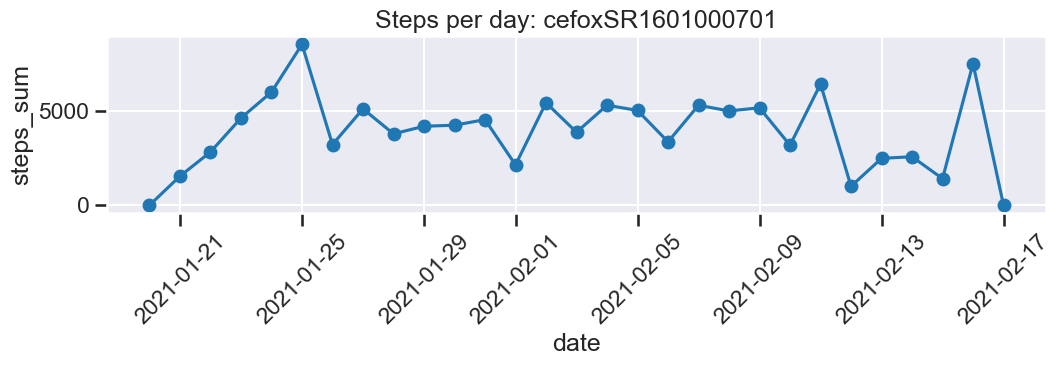

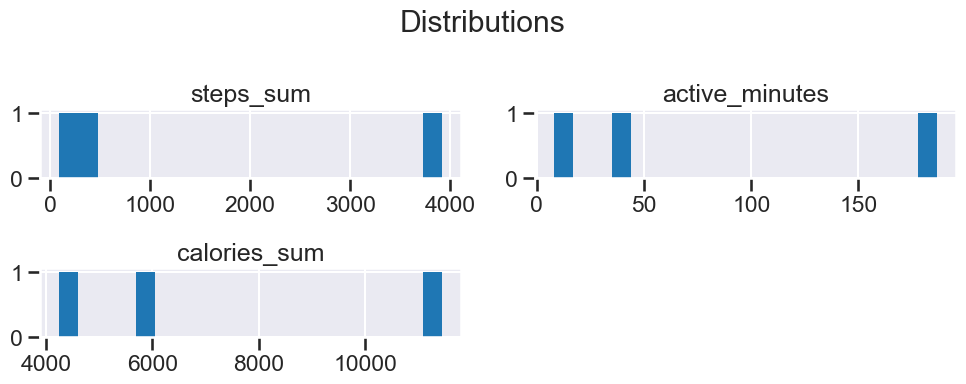

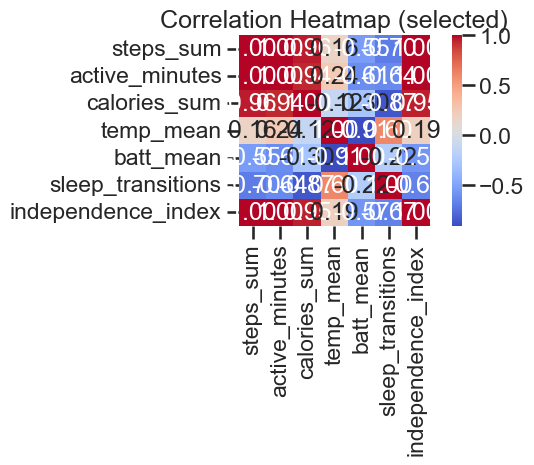

In [25]:
# 20) Visualization: Activity Trends, Histograms, Correlations
if 'sensor_daily' in globals() and not sensor_daily.empty:
    # Pick a subject with most daily rows
    top_subject = (sensor_daily.groupby('subject_id')['date'].count().sort_values(ascending=False).index[0])
    fig, ax = plt.subplots(1,1, figsize=(11,4))
    sd = sensor_daily[sensor_daily['subject_id']==top_subject].sort_values('date')
    ax.plot(sd['date'], sd['steps_sum'], marker='o')
    ax.set_title(f'Steps per day: {top_subject}')
    ax.set_ylabel('steps_sum')
    ax.set_xlabel('date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if 'merged_scored' in globals() and not merged_scored.empty:
    ms = merged_scored.copy()
    cols_hist = [c for c in ['steps_sum','active_minutes','calories_sum'] if c in ms.columns]
    if cols_hist:
        ms[cols_hist].hist(bins=20, figsize=(10,4))
        plt.suptitle('Distributions')
        plt.tight_layout()
        plt.show()

    # Correlation heatmap for selected numeric columns
    num_cols = ms.select_dtypes(include='number').columns.tolist()
    # reduce to avoid overly large plots
    keep = [c for c in ['steps_sum','active_minutes','calories_sum','temp_mean','batt_mean','sleep_transitions','independence_index'] if c in num_cols]
    if len(keep) >= 2:
        corr = ms[keep].corr()
        plt.figure(figsize=(7,5))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
        plt.title('Correlation Heatmap (selected)')
        plt.tight_layout()
        plt.show()
else:
    print('Data not ready for visualization.')

In [ ]:
# 21) Train/Test Split and Simple Baseline Model (Logistic)
if 'merged_scored' in globals() and not merged_scored.empty:
    dfm = merged_scored.copy()
    # Determine target: prefer 'target' from evaluation table; else use median of independence_index
    if 'target' in dfm.columns and dfm['target'].notna().any():
        y = dfm['target'].fillna(dfm['target'].median()).astype(int)
    else:
        if 'independence_index' in dfm.columns and dfm['independence_index'].notna().any():
            med = float(dfm['independence_index'].median())
            y = (dfm['independence_index'] > med).astype(int)
        else:
            print('No suitable target; skip model.')
            y = None

    if y is not None:
        # Features: numeric z/winsorized engineered features, drop identifiers and target
        drop_cols = {'subject_id','target'}
        X = dfm.select_dtypes(include='number').drop(columns=[c for c in drop_cols if c in dfm.columns], errors='ignore')
        if X.shape[1] < 2:
            print('Not enough features; skip model.')
        else:
            class_counts = y.value_counts()
            stratify_arg = y if (y.nunique() >= 2 and class_counts.min() >= 2) else None
            ts = 0.33 if len(y) < 10 else 0.3
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42, stratify=stratify_arg)
            clf = LogisticRegression(max_iter=500)
            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            print('Baseline Logistic Regression')
            print(classification_report(y_test, preds, digits=3))
            print('Confusion Matrix:\n', confusion_matrix(y_test, preds))
else:
    print('merged_scored not available; skip modeling.')

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
# 22) Performance Optimization (Caching, Incremental Saves, Parquet Export)
OPT_PATH = BASE_PATH / 'outputs'
OPT_PATH.mkdir(exist_ok=True)

if 'sensor_daily' in globals() and not sensor_daily.empty:
    sensor_daily.to_parquet(OPT_PATH / 'sensor_daily.parquet', index=False)
    print('Saved sensor_daily parquet')
if 'merged_scored' in globals() and not merged_scored.empty:
    merged_scored.to_parquet(OPT_PATH / 'merged_scored.parquet', index=False)
    print('Saved merged_scored parquet')

print('Optimization exports complete.')

In [26]:
# 23) Final Tidy Dataset Export and Integrity Checks
EXPORT_PATH = OPT_PATH

if 'merged_scored' in globals() and not merged_scored.empty:
    # Integrity: no duplicate subject_id
    dup = merged_scored['subject_id'].duplicated().sum()
    assert dup == 0, f'Duplicate subject_id rows found: {dup}'

    # Export CSV
    merged_scored.to_csv(EXPORT_PATH / 'merged_scored.csv', index=False, encoding='utf-8-sig')

    # Schema JSON
    schema = { 'columns': [], 'row_count': int(merged_scored.shape[0]) }
    for c in merged_scored.columns:
        schema['columns'].append({'name': c, 'dtype': str(merged_scored[c].dtype)})
    with open(EXPORT_PATH / 'merged_scored_schema.json', 'w', encoding='utf-8') as f:
        json.dump(schema, f, indent=2, ensure_ascii=False)
    print('Exported merged_scored.csv and schema JSON')
else:
    print('merged_scored not available; export skipped.')

NameError: name 'OPT_PATH' is not defined